In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Load the raw RNA data - # raw yscRNA-seq data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE122392 - Steinmetz L
raw_rna_steinmetz = pd.read_csv("/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Data/raw_rna_steinmetz.csv", header=0, sep=",", decimal=".")
protein_noise_weissman = pd.read_csv("/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Data/Protein_noise_Weissman.csv", header=0, sep=",", decimal=".")
rna_noise_steinmetz = pd.read_csv("/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Data/RNA_noise_Dhar.csv", header=0, sep=",", decimal=".")
all_features_rna = pd.read_csv("/Users/dhwani/Downloads/Filtered_nondup_MERGED_DATA_Yeast.txt", header=0, sep="\t", decimal=".")
rna_noise_acar = pd.read_csv('/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Data/Acar_rna_noise.csv', header=0, decimal=".")

In [ ]:
'''
# PREPROCESSING ACAR scRNA-seq data

#Acar lab data - 4 samples (DMSO n = 233, Guanine n = 258, MPA n = 85, Guanine MPA n = 268 cells)
from scipy.io import mmread
raw_rna_acar = mmread("/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Data/Acar_raw_data/GSE165686_yeastdropseq_dge.mtx")
gene_labels = pd.read_csv('/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Data/Acar_raw_data/GSE165686_features.tsv', header=0, sep='\t')
raw_rna_acar = raw_rna_acar.toarray()
raw_rna_acar = pd.DataFrame(raw_rna_acar)

# Calculating CV of all genes in the 4 different media #NO NEED TO RUN 
gene_labels["AVG_EXP_DMSO"] = raw_rna_acar.iloc[:, :233].mean(axis=1)
gene_labels["SD_DMSO"] = raw_rna_acar.iloc[:, :233].std(axis=1)
gene_labels["AVG_EXP_Gua"] = raw_rna_acar.iloc[:, 233:491].mean(axis=1)
gene_labels["SD_Gua"] = raw_rna_acar.iloc[:, 233:491].std(axis=1)
gene_labels["AVG_EXP_MPA"] = raw_rna_acar.iloc[:, 491:576].mean(axis=1)
gene_labels["SD_MPA"] = raw_rna_acar.iloc[:, 491:576].std(axis=1)
gene_labels["AVG_EXP_GuaMPA"] = raw_rna_acar.iloc[:, 576:844].mean(axis=1)
gene_labels["SD_GuaMPA"] = raw_rna_acar.iloc[:, 576:844].std(axis=1)

gene_labels["CV_DMSO"] = 100 * gene_labels["SD_DMSO"]/gene_labels["AVG_EXP_DMSO"]
gene_labels["CV_Gua"] = 100 * gene_labels["SD_Gua"]/gene_labels["AVG_EXP_Gua"]
gene_labels["CV_MPA"] = 100 * gene_labels["SD_MPA"]/gene_labels["AVG_EXP_MPA"]
gene_labels["CV_GuaMPA"] = 100 * gene_labels["SD_GuaMPA"]/gene_labels["AVG_EXP_GuaMPA"]

gene_labels.columns.values[1] = 'ORF'

gene_labels.to_csv('/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Data/Acar_raw_data/Acar_rna_noise.csv', index=False)  # index=False to exclude the index column in the file
'''

In [29]:
intersect_features = list(set(rna_noise_steinmetz.columns) & set(protein_noise_weissman.columns))
print("rna_noise_steinmetz columns",len(list(set(rna_noise_steinmetz.columns) & set(protein_noise_weissman.columns))))
print(len(rna_noise_steinmetz.columns))
print(len(protein_noise_weissman.columns))
print("extra protein features",list(set(protein_noise_weissman.columns) - set(intersect_features)))
print("extra rna features",list(set(rna_noise_steinmetz.columns) - set(intersect_features)))

rna_noise_steinmetz columns 32
34
44
extra protein features ['PercPosCor_withinTFs', 'Gb_GCN4.AA', 'SdStrPosCorTF', 'Prom_H3K79me3_vsH3', 'Acetylation', 'mRNA_HL_Mins', 'TATAbox', 'STRE_elem', 'V_PrNO500', 'MeanStrPosCorTF', 'geneName.y', 'Df_stractrep_ov']
extra rna features ['MedPosDM_SD_TFYT', 'maxDM_TFYT']


In [6]:
all_features_rna.rename(columns={'Gene': 'COMMON'}, inplace=True)
all_features_rna = pd.merge(all_features_rna, rna_noise_steinmetz, how='inner', on=['COMMON'],suffixes=('', '_y')) #adds ORF, chr and loc columns
all_features_rna.drop(all_features_rna.filter(regex='_y$').columns, axis=1, inplace=True) #removes duplicated columns

In [120]:
rna_noise_acar = pd.merge(rna_noise_acar, rna_noise_steinmetz[['ORF','DM_YPD']], on='ORF', how='inner')
rna_noise_acar = pd.merge(rna_noise_acar, protein_noise_weissman[['ORF','DM_YPD']], on='ORF', how='inner')
rna_noise_acar.rename(columns={'DM_YPD_x': 'DM_YPD_RNA', 'DM_YPD_y': 'DM_YPD_PROTEIN'}, inplace=True)
rna_noise_acar.head

<bound method NDFrame.head of           ORF  AVG_EXP_DMSO   SD_DMSO  AVG_EXP_Gua    SD_Gua  AVG_EXP_MPA  \
0     YAL005C      0.497854  0.942870     0.197674  0.651005     0.341176   
1     YAL007C      0.248927  0.547574     0.085271  0.293404     0.294118   
2     YAL012W      0.819742  1.043100     0.519380  0.814277     1.494118   
3     YAL016W      0.042918  0.241857     0.023256  0.174887     0.000000   
4     YAL023C      0.072961  0.276677     0.000000  0.000000     0.000000   
...       ...           ...       ...          ...       ...          ...   
1586  YPL137C      0.000000  0.000000     0.000000  0.000000     0.000000   
1587  YPL162C      0.000000  0.000000     0.000000  0.000000     0.000000   
1588  YPL227C      0.000000  0.000000     0.000000  0.000000     0.000000   
1589  YPR168W      0.000000  0.000000     0.000000  0.000000     0.000000   
1590  YPR171W      0.000000  0.000000     0.000000  0.000000     0.000000   

        SD_MPA  AVG_EXP_GuaMPA  SD_GuaMPA    

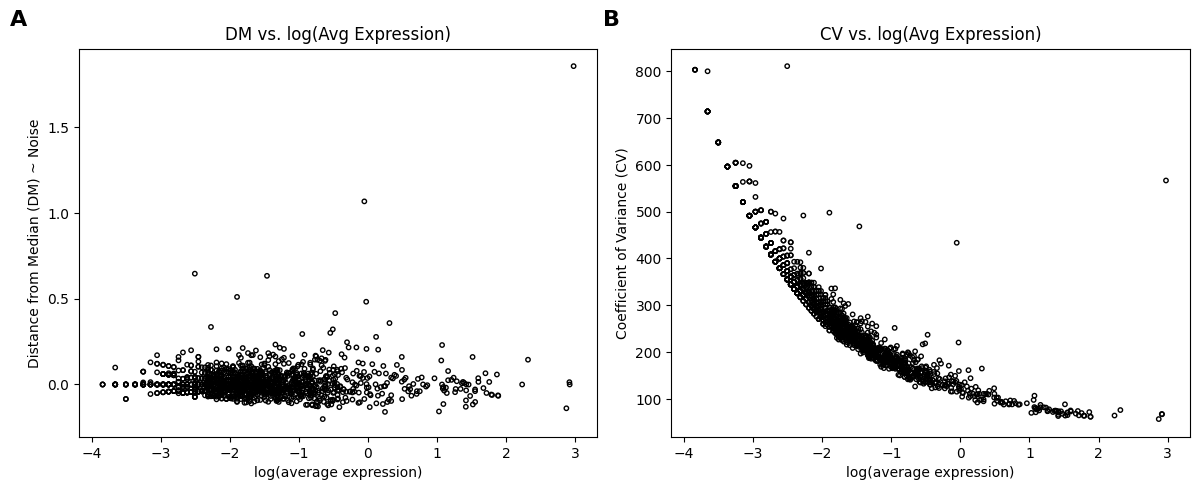

In [140]:
#Plotting CV & DM vs log(avg expression)
# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First scatter plot
ax1.scatter(np.log(rna_noise_acar['AVG_EXP_DMSO']), rna_noise_acar['DMSO_DM'], facecolors='none', edgecolors='black', s=10)
ax1.set_xlabel("log(average expression)")
ax1.set_ylabel("Distance from Median (DM) ~ Noise")
ax1.set_title("DM vs. log(Avg Expression)")

# Add label "A" in the top-left corner of the first subplot
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Second scatter plot
ax2.scatter(np.log(rna_noise_acar['AVG_EXP_DMSO']), rna_noise_acar['CV_DMSO'], facecolors='none', edgecolors='black', s=10)
ax2.set_xlabel("log(average expression)")
ax2.set_ylabel("Coefficient of Variance (CV)")
ax2.set_title("CV vs. log(Avg Expression)")

# Add label "B" in the top-left corner of the second subplot
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Display the plots
plt.tight_layout()
plt.savefig("/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Figures/CV_DM_vs_AvgExp.png", dpi=300)
plt.show()

0.4630246717638949
Correlation: nan nan
Correlation: 0.2501821330781209 1.4328432716403258e-20


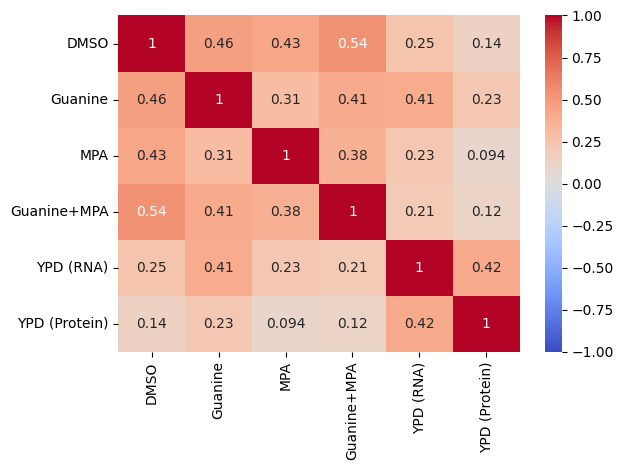

In [148]:
#correlation of noise between different media conditions and between RNA and protein
from scipy.stats import pearsonr
import seaborn as sns
print(rna_noise_acar['DMSO_DM'].corr(rna_noise_acar['Gua_DM']))
print("Correlation:", *pearsonr(rna_noise_acar.dropna(subset=['DMSO_DM', 'DM_YPD_RNA'])['DMSO_DM'], rna_noise_acar.dropna(subset=['DMSO_DM', 'DM_YPD_RNA'])['DM_YPD_RNA']))

new_labels = ['DMSO', 'Guanine', 'MPA', 'Guanine+MPA', 'YPD (RNA)', 'YPD (Protein)']
sns.heatmap(rna_noise_acar[['DMSO_DM','Gua_DM','MPA_DM','GuaMPA_DM','DM_YPD_RNA','DM_YPD_PROTEIN']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=new_labels, yticklabels=new_labels)
plt.tight_layout()
plt.savefig("/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Figures/noise_correlation_across_media.png", dpi=300)
plt.show()

In [7]:
#feature selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer

In [158]:
X.shape

(4581, 282)

In [184]:
X = all_features_rna.drop(['COMMON','ORF','AVGEXP_YPD', 'AVGEXP_SD', 'DM_YPD', 'DM_YPD_CLASS', 'DM_SD'], axis=1)
y = all_features_rna["DM_YPD"] # y is the variable to be predicted i.e. noise = DM value in YPD medium
imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"
X = imputer.fit_transform(X)

In [152]:
# Applying SelectKBest with ANOVA F-value
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

SelectKBest(k='all', score_func=<function f_regression at 0x2864a4860>)

(array([240.,  16.,   7.,   7.,   5.,   0.,   0.,   0.,   0.,   7.]),
 array([5.57919939e-04, 4.99240788e+01, 9.98475998e+01, 1.49771121e+02,
        1.99694642e+02, 2.49618163e+02, 2.99541683e+02, 3.49465204e+02,
        3.99388725e+02, 4.49312246e+02, 4.99235767e+02]),
 <BarContainer object of 10 artists>)

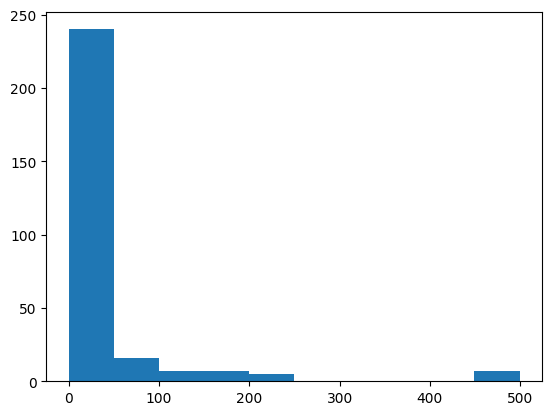

In [90]:
plt.hist(selector.scores_)
#plt.hist(selector.pvalues_)

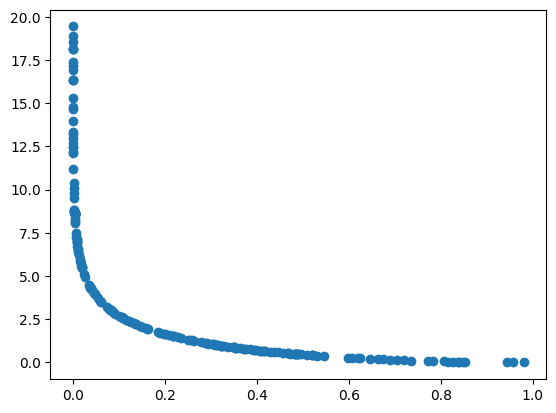

In [89]:
mask = selector.pvalues_ >0.00001
plt.scatter(selector.pvalues_[mask],selector.scores_[mask])

In [157]:
# Applying SelectKBest with ANOVA F-value #this time select for k features
selector = SelectKBest(score_func=f_regression, k=100)
selector.fit(X, y)

SelectKBest(k=100, score_func=<function f_regression at 0x2864a4860>)

In [185]:
#Top 17 features
selector = SelectKBest(score_func=f_regression, k=17)
selector.fit(X, y)
features = all_features_rna.drop(['COMMON','ORF','AVGEXP_YPD', 'AVGEXP_SD', 'DM_YPD', 'DM_YPD_CLASS', 'DM_SD'], axis=1).columns
selected_features = features[selector.get_support(indices=True)]
selected_features

Index(['Num_RegTF_YeastractYT', 'maxDM_TFYT', 'NumPosCor_withinTFs',
       'NumNegCor_withinTFs', 'PercNegCor_withinTFs', 'PercPosCorWN_OVsites',
       'N_TFSites600', 'N_TFSites700', 'NumSites', 'NumOverlaps',
       'RatOverlap.Numsites', 'NumCoopTF_Yang2010', 'NumCoopTF_Chen2012',
       'PercCoopTF_Yang2010', 'Gb_H3K79me3_vsH3', 'Pugh2004_SAGA_Dominance',
       'Pugh2004_TFIID_Dominance'],
      dtype='object')

In [107]:
len(list(set(dhar_selected_features) & set(selected_features)))
len(selected_features)
np.sum(selector.scores_ > 13.5) #the 100 best features have f-value  > 13.5 and p-value < 0.00001

100

In [163]:
from sklearn.model_selection import train_test_split

X_selected = selector.transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 0.07791601080574843
R2 Score: 0.17796615049978992


Results for k=5:
  Mean Squared Error: 0.0643185876132315
  R2 Score: 0.10981234608007137
--------------------------------------------------
Results for k=10:
  Mean Squared Error: 0.062372158141024425
  R2 Score: 0.1368578039812273
--------------------------------------------------
Results for k=16:
  Mean Squared Error: 0.06146179624651784
  R2 Score: 0.14791767848278947
--------------------------------------------------
Results for k=17:
  Mean Squared Error: 0.06133877801232016
  R2 Score: 0.14959340219124886
--------------------------------------------------
Results for k=18:
  Mean Squared Error: 0.061436805432256415
  R2 Score: 0.1477808685769566
--------------------------------------------------
Results for k=20:
  Mean Squared Error: 0.06152567542026567
  R2 Score: 0.14652007695081543
--------------------------------------------------
Results for k=25:
  Mean Squared Error: 0.061537267392205885
  R2 Score: 0.14636798203739582
--------------------------------------------------


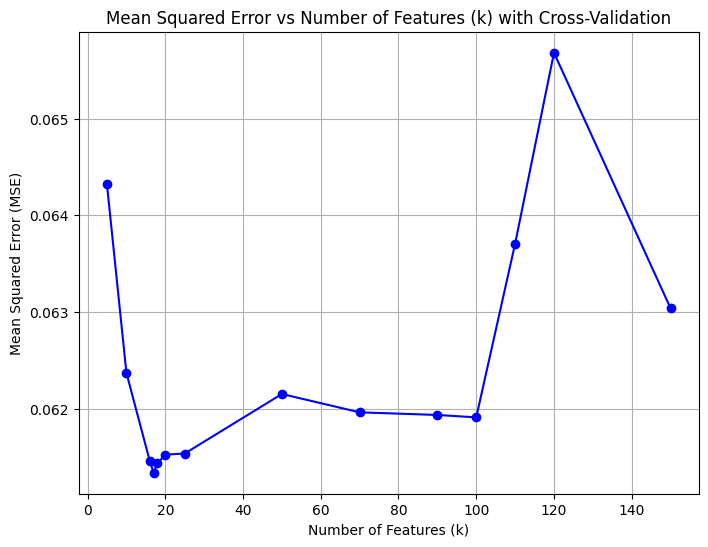

In [175]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# List of different values of k to try
k_values = [5, 10, 16, 17, 18, 20, 25, 50, 70, 90, 100, 110, 120, 150]

# Store MSE for each value of k
mean_mse_values = []

# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Loop over different choices for k
for k in k_values:
    # Apply SelectKBest with ANOVA F-value for different k values
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X, y)

    # Initialize the model
    model = LinearRegression()

    # Use cross-validation to compute MSE for each fold
    mse_scores = cross_val_score(model, X_selected, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    r2_scores = cross_val_score(model, X_selected, y, scoring='r2', cv=cv, n_jobs=-1)

    # Since cross_val_score returns negative MSE, we take the negative of it to get positive values
    mean_mse = -np.mean(mse_scores)  # average MSE across folds
    mean_r2 = np.mean(r2_scores)  # average R2 across folds

    # Append the mean MSE value for this k
    mean_mse_values.append(mean_mse)
    
    # Print the results for each value of k
    print(f"Results for k={k}:")
    print(f"  Mean Squared Error: {mean_mse}")
    print(f"  R2 Score: {mean_r2}")
    print("-" * 50)

# Plot MSE vs k
plt.figure(figsize=(8, 6))
plt.plot(k_values, mean_mse_values, marker='o', linestyle='-', color='b')
plt.title('Mean Squared Error vs Number of Features (k) with Cross-Validation')
plt.xlabel('Number of Features (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

In [114]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
# Compute R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 0.08052003161322052
R-squared: 0.15049306471923551


In [164]:
rna_noise_steinmetz.columns

Index(['COMMON', 'AVGEXP_YPD', 'AVGEXP_SD', 'DM_YPD', 'DM_YPD_CLASS', 'DM_SD',
       'AvPromNucOcc', 'Num_RegTF_YeastractYT', 'MedPosDM_SD_TFYT',
       'maxDM_TFYT', 'PosCorTF_YT', 'NumPosCor_withinTFs',
       'NumNegCor_withinTFs', 'PercNegCor_withinTFs', 'PercPosCorWN_OVsites',
       'N_TFSites400', 'N_TFSites500', 'N_TFSites600', 'N_TFSites700',
       'N_TFSites800', 'N_TFSites900', 'N_TFSites1000', 'NumSites',
       'NumOverlaps', 'RatOverlap.Numsites', 'NumCoopTF_Yang2010',
       'NumCoopTF_Chen2012', 'PercCoopTF_Yang2010', 'Gb_H3K79me3_vsH3',
       'Pugh2004_SAGA_Dominance', 'Pugh2004_TFIID_Dominance', 'ORF',
       'location', 'chr'],
      dtype='object')

In [176]:
#Based on selected features by Dhar
X_baseline = rna_noise_steinmetz.drop(['COMMON','ORF','AVGEXP_YPD', 'AVGEXP_SD', 'DM_YPD', 'DM_YPD_CLASS', 'DM_SD','location', 'chr'], axis=1)
y_baseline = rna_noise_steinmetz["DM_YPD"] # y is the variable to be predicted i.e. noise = DM value in YPD medium
imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"
X_baseline = imputer.fit_transform(X_baseline)
'''
# Split the data into training and testing sets
X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = train_test_split(X_baseline, y_baseline, test_size=0.2, random_state=42)

model.fit(X_baseline_train, y_baseline_train)

# Make predictions and evaluate the model
y_baseline_pred = model.predict(X_baseline_test)
mse_baseline = mean_squared_error(y_baseline_test, y_baseline_pred)
print("Mean Squared Error:", mse_baseline)
# Compute R-squared
r2_baseline = r2_score(y_baseline_test, y_baseline_pred)
print("R-squared:", r2_baseline)
'''
# Initialize model
model = LinearRegression()

# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Compute cross-validated MSE
mse_scores = cross_val_score(model, X_baseline, y_baseline, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
r2_scores = cross_val_score(model, X_baseline, y_baseline, scoring='r2', cv=cv, n_jobs=-1)

# Since cross_val_score returns negative MSE, we take the negative of it to get positive values
mean_mse = -np.mean(mse_scores)  # average MSE across folds
mean_r2 = np.mean(r2_scores)     # average R2 across folds

print(f"Cross-validated Mean Squared Error (MSE): {mean_mse}")
print(f"Cross-validated R-squared (R2): {mean_r2}")

Cross-validated Mean Squared Error (MSE): 0.06156981708796936
Cross-validated R-squared (R2): 0.14583066762392596


In [177]:
X_baseline.shape

(4581, 25)

In [116]:
#How much variation does the model explain in the training data?
y_baseline_train_pred = model.predict(X_baseline_train)
mse_baseline_train = mean_squared_error(y_baseline_train, y_baseline_train_pred)
print("Mean Squared Error:", mse_baseline_train)
# Compute R-squared
r2_baseline_train = r2_score(y_baseline_train, y_baseline_train_pred)
print("R-squared:", r2_baseline_train)
# The variation explained is not substantially larger so hopefully there is no overfitting

Mean Squared Error: 0.05550376722131881
R-squared: 0.1693676014130696


In [181]:
# Integrated model - contains all features. Explains 

X = all_features_rna.drop(['COMMON','ORF','AVGEXP_YPD', 'AVGEXP_SD', 'DM_YPD', 'DM_YPD_CLASS', 'DM_SD'], axis=1)
y = all_features_rna["DM_YPD"] # y is the variable to be predicted i.e. noise = DM value in YPD medium
imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"
X = imputer.fit_transform(X)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

'''
# Initialize the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
# Compute R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

#variation explained in training data
y_train_pred = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training Mean Squared Error:", mse_train)
# Compute R-squared
r2_train = r2_score(y_train, y_train_pred)
print("Training R-squared:", r2_train)
'''
# Initialize model
model = LinearRegression()

# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Compute cross-validated MSE
mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)

# Since cross_val_score returns negative MSE, we take the negative of it to get positive values
mean_mse = -np.mean(mse_scores)  # average MSE across folds
mean_r2 = np.mean(r2_scores)     # average R2 across folds

print(f"Cross-validated Mean Squared Error (MSE): {mean_mse}")
print(f"Cross-validated R-squared (R2): {mean_r2}")

Cross-validated Mean Squared Error (MSE): 0.06752833060504347
Cross-validated R-squared (R2): 0.0548198384734818


In [124]:
#Variation explained by specific features
X = all_features_rna["TATAbox"]
y = all_features_rna["DM_YPD"]
X = X.to_frame()
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the model
model = LinearRegression()
model.fit(X_train, y_train)

# Get the R² value for the training data (fraction of variance explained)
r2_train = model.score(X_train, y_train)

print("Fraction of variance explained on training data (R²):", r2_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
# Compute R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Fraction of variance explained on training data (R²): 0.01886343670764068
Mean Squared Error: 0.09303108473557824
R-squared: 0.018498253214915494


Average R²: 0.070
Average MSE: 0.067

R² scores for each fold: [ 0.13503746 -0.12746308  0.24171176  0.03771249  0.21136015 -0.05101047
  0.13752671 -0.08168793  0.14008585 -0.11795522  0.18961876 -0.11998753
  0.10579648 -0.00670927 -0.02758065  0.01041439  0.11065231  0.09661645
  0.16178502  0.23053328  0.15856098  0.01525811  0.08079964  0.1945322
  0.17453691  0.10416415  0.10314569  0.10327612 -0.17447841  0.0554375 ]
MSE scores for each fold: [0.08822803 0.059411   0.05301839 0.10171057 0.06402715 0.05131502
 0.04760544 0.07421019 0.0568851  0.08253673 0.05009235 0.10188854
 0.06993742 0.05489909 0.04748156 0.08110272 0.06929025 0.06099662
 0.07732124 0.05578342 0.06460308 0.06272693 0.06481675 0.05968996
 0.05595676 0.08377665 0.07787108 0.04989613 0.07115434 0.06999878]
Average R²: 0.106
Average MSE: 0.065

R² scores for each fold: [ 0.14954093  0.12128702  0.2406699   0.07317842  0.22342769 -0.01596249
  0.15410928 -0.01938827  0.16137172 -0.06904278  0.18931667 -0.06752434
 

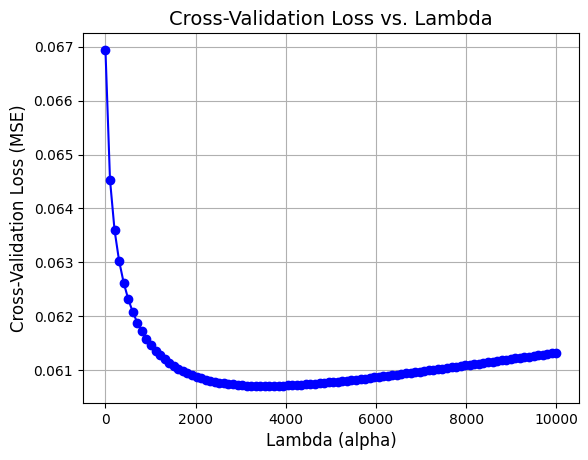

In [15]:
#need to normalise for ridge regression

from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Generate a range of values for alpha (lambda)
#alphas = np.logspace(-6, 6, 10000)  # Ranges from 10^-6 to 10^6
alphas = np.linspace(0.1, 10000, 100)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the features and transform the data
X_scaled = scaler.fit_transform(X)

# Initialize lists to store cross-validation losses
cv_norm_losses = []
cv_norm_r2 = []

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Loop through each alpha value, perform cross-validation, and calculate the mean CV loss (MSE)
for alpha in alphas:
    model = Ridge(alpha=alpha)  # Define model with current alpha value
    # Define the scoring metrics: R² and negative MSE
    scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
    # Perform cross-validation with both metrics
    results = cross_validate(model, X_scaled, y, scoring=scoring, cv=cv, return_train_score=False)

    # Extract R² and MSE values for each fold
    r2_scores = results['test_r2']
    mse_scores = -results['test_mse']  # Negate to make MSE positive

    
    # Mean squared error, so we negate to make it positive
    cv_norm_losses.append(mse_scores.mean())
    cv_norm_r2.append(r2_scores.mean())
    
    # Print average R² and MSE across all folds
    print(f"Average R²: {r2_scores.mean():.3f}")
    print(f"Average MSE: {mse_scores.mean():.3f}")
    
    # Optional: print R² and MSE for each fold
    print("\nR² scores for each fold:", r2_scores)
    print("MSE scores for each fold:", mse_scores)

plt.plot(alphas, cv_norm_losses, marker='o', linestyle='-', color='b')
#plt.xscale('log')  # Use a log scale for x-axis (since lambda often spans several orders of magnitude)
plt.xlabel('Lambda (alpha)', fontsize=12)
plt.ylabel('Cross-Validation Loss (MSE)', fontsize=12)
plt.title('Cross-Validation Loss vs. Lambda', fontsize=14)
plt.grid(True)
plt.show()

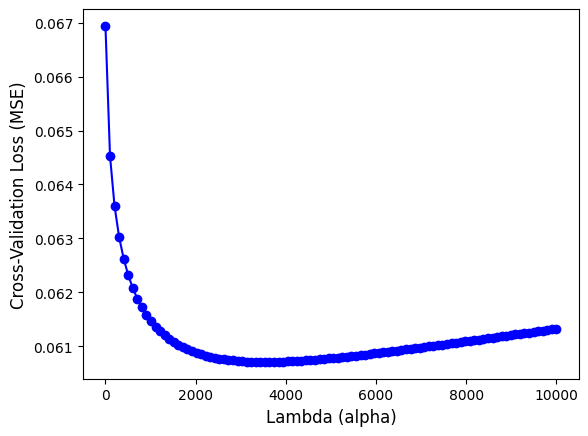

In [162]:
plt.plot(alphas, cv_norm_losses, marker='o', linestyle='-', color='b')
#plt.xscale('log')  # Use a log scale for x-axis (since lambda often spans several orders of magnitude)
plt.xlabel('Lambda (alpha)', fontsize=12)
plt.ylabel('Cross-Validation Loss (MSE)', fontsize=12)
#plt.title('Cross-Validation Loss vs. Lambda', fontsize=14)
#plt.grid(True)
plt.savefig("/Users/dhwani/Documents/Coursework/SEM3/ML for functional genomics - Prof. David Knowles/Project/Figures/Cross-Validation_Loss_vs_Lambda.png", dpi=300)
plt.show()

In [18]:
np.argmin(cv_norm_losses)*(9999.9/100) # alpha = 3500 for minimum loss
alphas[np.argmin(cv_norm_losses)]

3535.4181818181814

In [183]:
X = all_features_rna.drop(['COMMON','ORF','AVGEXP_YPD', 'AVGEXP_SD', 'DM_YPD', 'DM_YPD_CLASS', 'DM_SD'], axis=1)
y = all_features_rna["DM_YPD"] # y is the variable to be predicted i.e. noise = DM value in YPD medium
imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"
X = imputer.fit_transform(X)

# Initialize Ridge regression model
ridge_model = Ridge(alpha=3535.418)  # You can change the alpha value to control regularization strength

# Set up cross-validation (e.g., 5-fold cross-validation)
#cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform cross-validation for MSE and R2 score
mse_scores = cross_val_score(ridge_model, X_baseline, y_baseline, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
r2_scores = cross_val_score(ridge_model, X_baseline, y_baseline, scoring='r2', cv=cv, n_jobs=-1)

# Since cross_val_score returns negative MSE, we take the negative of it to get positive values
mean_mse = -np.mean(mse_scores)  # average MSE across folds
mean_r2 = np.mean(r2_scores)     # average R2 across folds

# Print results
print(f"Cross-validated Mean Squared Error (MSE): {mean_mse}")
print(f"Cross-validated R-squared (R2): {mean_r2}")

Cross-validated Mean Squared Error (MSE): 0.06282442301346239
Cross-validated R-squared (R2): 0.12809597091735078
